## Clustering and Regressions

We have 2 basic data sources:

[Merged Sales] - This is sales data by zip code. It came from https://www.redfin.com/news/data-center/ and it's got a lot of stats in there. Most of the data is medians so it doesn't tell us much about the outliers which almost certainly are skewing some of the data pretty heavily. The Price per SQ Foot is one way to see a little bit of how the market is shaped. These are broken out by zip code and month.

[2018_demographic data] - This is 2018 demographic info by zip code.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
import seaborn as sns
from sklearn.datasets.samples_generator import make_blobs
from sklearn.cluster import Birch,MiniBatchKMeans
sns.set()

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


### Import Data
#### Demographics

In [2]:
df_demo = pd.read_csv("2018_demographic_data.csv", delimiter=',')
print(df_demo.shape) # removed some of the blank columns and columns with strings in excel
df_demo.head()

(14342, 2157)


,Geo_FIPS,Geo_GEOID,Geo_NAME,Geo_QName,Geo_STUSAB,Geo_SUMLEV,Geo_GEOCOMP,Geo_FILEID,Geo_LOGRECNO,Geo_US,...,SE_A10065_001,SE_A10065_002,SE_A10066_001,SE_A10066_002,SE_A10066_003,SE_A10066_004,SE_A10066_005,SE_A10066_006,SE_A10066_007,SE_A10066_008
0,600601,86000US00601,ZCTA5 00601,ZCTA5 00601,pr,860,0,ACSSF,7459,NaN,...,3237.0,1849.0,5517.0,1346.0,1768.0,1222.0,889.0,214.0,46.0,32.0
1,600602,86000US00602,ZCTA5 00602,ZCTA5 00602,pr,860,0,ACSSF,7460,NaN,...,5636.0,2721.0,12738.0,3107.0,4024.0,2467.0,2345.0,588.0,163.0,44.0
2,600603,86000US00603,ZCTA5 00603,ZCTA5 00603,pr,860,0,ACSSF,7461,NaN,...,8627.0,4772.0,19233.0,5121.0,6256.0,4058.0,2523.0,1085.0,118.0,72.0
3,600606,86000US00606,ZCTA5 00606,ZCTA5 00606,pr,860,0,ACSSF,7462,NaN,...,975.0,588.0,2014.0,474.0,693.0,343.0,343.0,120.0,19.0,22.0
4,600610,86000US00610,ZCTA5 00610,ZCTA5 00610,pr,860,0,ACSSF,7463,NaN,...,4317.0,2125.0,8858.0,2194.0,2972.0,1679.0,1440.0,486.0,55.0,32.0


In [3]:
df_demo.dtypes

Geo_FIPS           int64
Geo_GEOID         object
Geo_NAME          object
Geo_QName         object
Geo_STUSAB        object
                  ...   
SE_A10066_004    float64
SE_A10066_005    float64
SE_A10066_006    float64
SE_A10066_007    float64
SE_A10066_008    float64
Length: 2157, dtype: object

In [4]:
# let's inspect the variable values
for var in df_demo.columns:
    print(var, df_demo[var].unique()[0:20], '\n')

Geo_FIPS [600601 600602 600603 600606 600610 600612 600616 600617 600622 600623
 600624 600627 600631 600637 600638 600641 600646 600647 600650 600652] 

Geo_GEOID ['86000US00601' '86000US00602' '86000US00603' '86000US00606'
 '86000US00610' '86000US00612' '86000US00616' '86000US00617'
 '86000US00622' '86000US00623' '86000US00624' '86000US00627'
 '86000US00631' '86000US00637' '86000US00638' '86000US00641'
 '86000US00646' '86000US00647' '86000US00650' '86000US00652'] 

Geo_NAME ['ZCTA5 00601' 'ZCTA5 00602' 'ZCTA5 00603' 'ZCTA5 00606' 'ZCTA5 00610'
 'ZCTA5 00612' 'ZCTA5 00616' 'ZCTA5 00617' 'ZCTA5 00622' 'ZCTA5 00623'
 'ZCTA5 00624' 'ZCTA5 00627' 'ZCTA5 00631' 'ZCTA5 00637' 'ZCTA5 00638'
 'ZCTA5 00641' 'ZCTA5 00646' 'ZCTA5 00647' 'ZCTA5 00650' 'ZCTA5 00652'] 

Geo_QName ['ZCTA5 00601' 'ZCTA5 00602' 'ZCTA5 00603' 'ZCTA5 00606' 'ZCTA5 00610'
 'ZCTA5 00612' 'ZCTA5 00616' 'ZCTA5 00617' 'ZCTA5 00622' 'ZCTA5 00623'
 'ZCTA5 00624' 'ZCTA5 00627' 'ZCTA5 00631' 'ZCTA5 00637' 'ZCTA5 00638'
 'ZCTA5 0

In [5]:
#To have an ideal of the label
no_columns = df_demo.columns
for col in no_columns:
    print('var: ', col, ' labels: ',df_demo[col].nunique())
print('total label: ', len(df_demo))

var:  Geo_FIPS  labels:  14342
var:  Geo_GEOID  labels:  14342
var:  Geo_NAME  labels:  14342
var:  Geo_QName  labels:  14342
var:  Geo_STUSAB  labels:  2
var:  Geo_SUMLEV  labels:  1
var:  Geo_GEOCOMP  labels:  1
var:  Geo_FILEID  labels:  1
var:  Geo_LOGRECNO  labels:  14342
var:  Geo_US  labels:  0
var:  Geo_ZCTA3  labels:  412
var:  Geo_ZCTA5  labels:  14342
var:  SE_A00001_001  labels:  9313
var:  SE_A00002_001  labels:  9313
var:  SE_A00002_002  labels:  14174
var:  SE_A00002_003  labels:  14341
var:  SE_A00003_001  labels:  14335
var:  SE_A00003_002  labels:  14333
var:  SE_A00003_003  labels:  12518
var:  SE_A02001_001  labels:  9313
var:  SE_A02001_002  labels:  7493
var:  SE_A02001_003  labels:  7595
var:  SE_A02002_001  labels:  9313
var:  SE_A02002_002  labels:  7493
var:  SE_A02002_003  labels:  1766
var:  SE_A02002_004  labels:  1763
var:  SE_A02002_005  labels:  1795
var:  SE_A02002_006  labels:  1240
var:  SE_A02002_007  labels:  2384
var:  SE_A02002_008  labels:  2978


### After inspecting the varables, let's drop of the variables

In [6]:
 df_demo.drop(columns=["Geo_US","Geo_GEOCOMP","Geo_FILEID","Geo_SUMLEV"],axis=1,inplace=True)

In [7]:
df_demo.head()

,Geo_FIPS,Geo_GEOID,Geo_NAME,Geo_QName,Geo_STUSAB,Geo_LOGRECNO,Geo_ZCTA3,Geo_ZCTA5,SE_A00001_001,SE_A00002_001,...,SE_A10065_001,SE_A10065_002,SE_A10066_001,SE_A10066_002,SE_A10066_003,SE_A10066_004,SE_A10066_005,SE_A10066_006,SE_A10066_007,SE_A10066_008
0,600601,86000US00601,ZCTA5 00601,ZCTA5 00601,pr,7459,6,601,17242,17242,...,3237.0,1849.0,5517.0,1346.0,1768.0,1222.0,889.0,214.0,46.0,32.0
1,600602,86000US00602,ZCTA5 00602,ZCTA5 00602,pr,7460,6,602,38442,38442,...,5636.0,2721.0,12738.0,3107.0,4024.0,2467.0,2345.0,588.0,163.0,44.0
2,600603,86000US00603,ZCTA5 00603,ZCTA5 00603,pr,7461,6,603,48814,48814,...,8627.0,4772.0,19233.0,5121.0,6256.0,4058.0,2523.0,1085.0,118.0,72.0
3,600606,86000US00606,ZCTA5 00606,ZCTA5 00606,pr,7462,6,606,6437,6437,...,975.0,588.0,2014.0,474.0,693.0,343.0,343.0,120.0,19.0,22.0
4,600610,86000US00610,ZCTA5 00610,ZCTA5 00610,pr,7463,6,610,27073,27073,...,4317.0,2125.0,8858.0,2194.0,2972.0,1679.0,1440.0,486.0,55.0,32.0


In [8]:
df_demo.describe()

,Geo_FIPS,Geo_LOGRECNO,Geo_ZCTA3,Geo_ZCTA5,SE_A00001_001,SE_A00002_001,SE_A00002_002,SE_A00002_003,SE_A00003_001,SE_A00003_002,...,SE_A10065_001,SE_A10065_002,SE_A10066_001,SE_A10066_002,SE_A10066_003,SE_A10066_004,SE_A10066_005,SE_A10066_006,SE_A10066_007,SE_A10066_008
count,1.434200e+04,14342.000000,14342.000000,14342.000000,14342.000000,14342.000000,14342.000000,14342.000000,14342.000000,14342.000000,...,14341.00000,14341.000000,14341.000000,14341.000000,14341.000000,14341.000000,14341.000000,14341.000000,14341.000000,14341.000000
mean,2.291190e+07,17727.937944,228.889695,22932.125575,10375.087645,10375.087645,1795.647491,42.333216,43.737675,42.333216,...,1961.99484,634.198522,3918.616205,1120.119796,1341.665923,628.200962,496.673454,212.506938,75.341608,44.107524
std,1.240014e+07,4199.607494,123.877561,12386.686612,14242.227126,14242.227126,7429.777418,59.090813,60.549136,59.090812,...,2908.26519,1132.635846,5306.201470,1659.426399,1761.707214,889.807564,728.930754,327.081842,132.302130,113.387976
min,6.006010e+05,7459.000000,6.000000,601.000000,0.000000,0.000000,0.000000,0.002093,0.002093,0.002093,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.301303e+07,14171.250000,130.000000,13031.250000,990.250000,990.250000,45.337077,5.447700,6.008449,5.447700,...,149.00000,31.000000,372.000000,94.000000,144.000000,53.000000,37.000000,13.000000,0.000000,0.000000
50%,2.342341e+07,17756.500000,234.000000,23406.000000,3855.500000,3855.500000,152.575800,22.992456,24.126155,22.992455,...,670.00000,170.000000,1463.000000,368.000000,547.000000,224.000000,168.000000,72.000000,22.000000,10.000000
75%,3.313317e+07,21341.750000,331.000000,33167.750000,14661.500000,14661.500000,969.813850,54.678400,56.429175,54.678398,...,2650.00000,700.000000,5585.000000,1478.000000,1939.000000,863.000000,670.000000,272.000000,92.000000,47.000000
max,4.444443e+07,24927.000000,444.000000,44431.000000,112425.000000,112425.000000,275429.200000,1170.639950,1273.487000,1170.640000,...,46427.00000,14563.000000,41910.000000,17874.000000,20619.000000,7709.000000,6000.000000,3542.000000,2176.000000,5228.000000


### Lets inspect categorical and numerical variables in the this huge dataset

In [9]:
def variables(x):
    # Number of Numberical and categorical variables
    categorical = [cal for cal in x.columns if x[cal].dtype=='O']
    numerical = [cal for cal in x.columns if x[cal].dtype!='O']
    print('No of categorical variables = {}'.format(len(categorical)))
    print('No of Numerical variables = {}'.format(len(numerical)))
variables(df_demo)

No of categorical variables = 4
No of Numerical variables = 2149


In [10]:
def cat():
    # Filtering categorical variables
    cat = [i for i in df_demo.columns if df_demo[i].dtype=='O']
    
    # printing number of categorical variable
    print('No.of categorical variables = {}'.format(cat),'\n')
    
    # Taking a peep on the structure of categorical variable
    print("Geo_GEOID  : {}".format(df_demo['Geo_GEOID'].unique()[0:3]))
    print("Geo_NAME   : {}".format(df_demo['Geo_NAME'].unique()[0:3]))
    print("Geo_QName  : {}".format(df_demo['Geo_QName'].unique()[0:3]))
    print("Geo_STUSAB : {}".format(df_demo['Geo_STUSAB'].unique()[0:3]),'\n')
    
    #checking the number of unique values in each of the categorical variable
    print("Geo_GEOID  : {}".format(df_demo['Geo_GEOID'].nunique()))
    print("Geo_NAME   : {}".format(df_demo['Geo_NAME'].nunique()))
    print("Geo_QName  : {}".format(df_demo['Geo_QName'].nunique()))
    print("Geo_STUSAB : {}".format(df_demo['Geo_STUSAB'].nunique()))
cat()

No.of categorical variables = ['Geo_GEOID', 'Geo_NAME', 'Geo_QName', 'Geo_STUSAB'] 

Geo_GEOID  : ['86000US00601' '86000US00602' '86000US00603']
Geo_NAME   : ['ZCTA5 00601' 'ZCTA5 00602' 'ZCTA5 00603']
Geo_QName  : ['ZCTA5 00601' 'ZCTA5 00602' 'ZCTA5 00603']
Geo_STUSAB : ['pr' 'us'] 

Geo_GEOID  : 14342
Geo_NAME   : 14342
Geo_QName  : 14342
Geo_STUSAB : 2


#### From above, Geo_QName and Geo_GEOID looks reductant, so lets drop it also

In [11]:
df_demo.drop(columns=["Geo_QName","Geo_GEOID"],axis=1,inplace=True)
df_demo.shape

(14342, 2151)

In [12]:
# Geo_Name has a combine categorical and Numerical variable. lets separate to make it easier to train our model
df_demo['zip_code'] = df_demo['Geo_NAME'].str[5:]# captures numerical part

# show dataframe
df_demo.head()

,Geo_FIPS,Geo_NAME,Geo_STUSAB,Geo_LOGRECNO,Geo_ZCTA3,Geo_ZCTA5,SE_A00001_001,SE_A00002_001,SE_A00002_002,SE_A00002_003,...,SE_A10065_002,SE_A10066_001,SE_A10066_002,SE_A10066_003,SE_A10066_004,SE_A10066_005,SE_A10066_006,SE_A10066_007,SE_A10066_008,zip_code
0,600601,ZCTA5 00601,pr,7459,6,601,17242,17242,267.9506,64.347690,...,1849.0,5517.0,1346.0,1768.0,1222.0,889.0,214.0,46.0,32.0,00601
1,600602,ZCTA5 00602,pr,7460,6,602,38442,38442,1255.4210,30.620812,...,2721.0,12738.0,3107.0,4024.0,2467.0,2345.0,588.0,163.0,44.0,00602
2,600603,ZCTA5 00603,pr,7461,6,603,48814,48814,1543.9250,31.616820,...,4772.0,19233.0,5121.0,6256.0,4058.0,2523.0,1085.0,118.0,72.0,00603
3,600606,ZCTA5 00606,pr,7462,6,606,6437,6437,152.1423,42.309073,...,588.0,2014.0,474.0,693.0,343.0,343.0,120.0,19.0,22.0,00606
4,600610,ZCTA5 00610,pr,7463,6,610,27073,27073,753.8562,35.912685,...,2125.0,8858.0,2194.0,2972.0,1679.0,1440.0,486.0,55.0,32.0,00610


In [13]:
# let's output variables with NA and fractions of the missing value
for i in df_demo.columns:
    if df_demo[i].isnull().sum() > 0:
        print(i, df_demo[i].isnull().mean())

SE_A01004_001 0.018337749267884534
SE_A01004_002 0.02851764049644401
SE_A01004_003 0.028935992190768374
SE_A10003_001 0.025031376377074328
SE_A10003B_001 0.08255473434667411
SE_A14006_001 0.0737693487658625
SE_A14007_001 0.0737693487658625
SE_A14007_002 0.08227583321712453
SE_A14007_003 0.5739785246130247
SE_A14007_004 0.9428252684423372
SE_A14007_005 0.7547064565611491
SE_A14007_006 0.9979779668107656
SE_A14007_007 0.8102775066239019
SE_A14007_008 0.7392274438711477
SE_A14007_009 0.6292706735462279
SE_A14007_010 0.08952726258541346
SE_A14008_001 0.04092874076140009
SE_A14009_001 0.02070840886905592
SE_A14009_002 0.02335796959977688
SE_A14009_003 0.35999163296611353
SE_A14009_004 0.6483754009203737
SE_A14009_005 0.506205550132478
SE_A14009_006 0.9220471342908939
SE_A14009_007 0.5524334123553201
SE_A14009_008 0.36368707293264535
SE_A14009_009 0.3289638823037233
SE_A14009_010 0.025728629200948264
SE_A14010_001 0.085901547901269
SE_A14011_001 0.05389764328545531
SE_A14012_001 0.1543020499

In [14]:
# drop any column with missing values greater than 5%
df_demo.drop(columns=["SE_A18007_006","SE_A18007_007","SE_A18007_005","SE_A18007_004",
                     "SE_A18007_003","SE_A18007_002","SE_A18008_011",
                     "SE_A18008_010","SE_A18008_009","SE_A18010_002",
                     "SE_A18010_003","SE_A18010_004","SE_A18010_005",
                     "SE_A18010_006","SE_A18010_007","SE_A18008_001","SE_A18008_002",
                     "SE_A18008_003","SE_A18008_008","SE_A18008_007","SE_A18008_006","SE_A18008_005",
                     "SE_A18008_004"],axis=1,inplace=True)
df_demo.shape

(14342, 2129)

In [15]:
# Using median instead of mean
df = df_demo.fillna(df_demo.median())

In [16]:
# created a dummy variable
df = pd.concat([df.loc[:,df.columns != "Geo_STUSAB"],
         pd.get_dummies(df[['Geo_STUSAB']], drop_first=True)],axis=1)
df.sample(5)

,Geo_FIPS,Geo_NAME,Geo_LOGRECNO,Geo_ZCTA3,Geo_ZCTA5,SE_A00001_001,SE_A00002_001,SE_A00002_002,SE_A00002_003,SE_A00003_001,...,SE_A10066_001,SE_A10066_002,SE_A10066_003,SE_A10066_004,SE_A10066_005,SE_A10066_006,SE_A10066_007,SE_A10066_008,zip_code,Geo_STUSAB_us
9561,29929932,ZCTA5 29932,20147,299,29932,221,221,3.075659,71.854511,73.102490,...,67.0,22.0,11.0,20.0,9.0,4.0,0.0,1.0,29932,1
7168,23323398,ZCTA5 23398,17754,233,23398,26,26,6.469049,4.019138,5.252223,...,20.0,14.0,6.0,0.0,0.0,0.0,0.0,0.0,23398,1
13988,43543536,ZCTA5 43536,24574,435,43536,161,161,10.453350,15.401769,15.401770,...,64.0,0.0,56.0,0.0,0.0,0.0,8.0,0.0,43536,1
1187,4404463,ZCTA5 04463,11773,44,4463,3190,3190,21.757220,146.617995,157.885700,...,1297.0,402.0,465.0,184.0,130.0,64.0,40.0,12.0,04463,1
926,3703785,ZCTA5 03785,11512,37,3785,2240,2240,37.511250,59.715421,60.494690,...,875.0,254.0,352.0,153.0,80.0,8.0,17.0,11.0,03785,1


In [17]:
# Confirm data is clean before moving forward
for i in df.columns:
    if df[i].isnull().sum() > 0:
        print(i, df[i].isnull().mean())
print("No missing value")

No missing value


In [18]:
#Normalize using standard scalar
#df_norm = preprocessing.StandardScaler().fit_transform(df)
#print(df_norm)

## Building classification model

In [19]:
## Looks like we goining drop another column to enable classifier run smoothly 

In [20]:
# Need to drop more columns
df.drop(columns=["Geo_NAME"],inplace=True,axis=1)
df.shape

(14342, 2128)

In [21]:
#Generating 1736 sample using make_blobs and 22 cluster points.
df, clusters = make_blobs(n_samples = 1736, centers = 22,cluster_std = 0.75, random_state=0)

In [22]:
# It's time to train and fit our model
model = Birch(branching_factor = 50, n_clusters = None, threshold = 1.5).fit(df)

In [23]:
# Birch already have a parameter label to make life easier. We can also use fit.predict
predictions = model.labels_
# lets take a glance
print(predictions)
print(len(predictions))

[ 7  1 17 ...  9 14  0]
1736


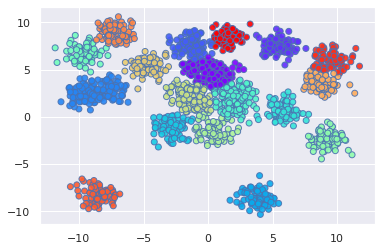

In [24]:
# Here we go!
plt.scatter(df[:,0], df[:,1], c=predictions, cmap='rainbow', alpha=0.9, edgecolors='b')
plt.show()

### Integrating into sales data

#### Sales

In [26]:
#sales = pd.read_csv("med_sale_price_yoy.csv", delimiter=',')
#sales.rename(columns={"Zip Code": "zip"}, inplace = True)
#sales.head()